In [10]:
import os
import time
import torch
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd


from hcnn.model import HarmonicFeatureExtractor, HarmonicFeatureExtractorConfig
from hcnn.utils import visualize_features, visualize_feature_embeddings, summarize_features, dimensionality_reduction
from data.trf.trf_dataset import TRFDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import all_estimators

import audio_separator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
config = HarmonicFeatureExtractorConfig()
config.sample_rate = 4000
config.n_fft = 256
config.hop_length = 32
config.n_harmonics = 2
config.n_filters_per_semitone = 1
fe = HarmonicFeatureExtractor(config=config)

In [12]:
seq_len_s = 30
sample_rate = 4000
ds = TRFDataset('./data/trf/1/thaat', labels=['Kalyan (thaat)/Bhoopali', 'Todi (thaat)/Multani'], target_length_seconds=seq_len_s, sample_rate=sample_rate)
print(len(ds))

30


In [13]:
x, label = ds[0]
print(ds.idx_to_label[label])
ipd.Audio(x, rate=ds.sample_rate)

Kalyan (thaat)/Bhoopali


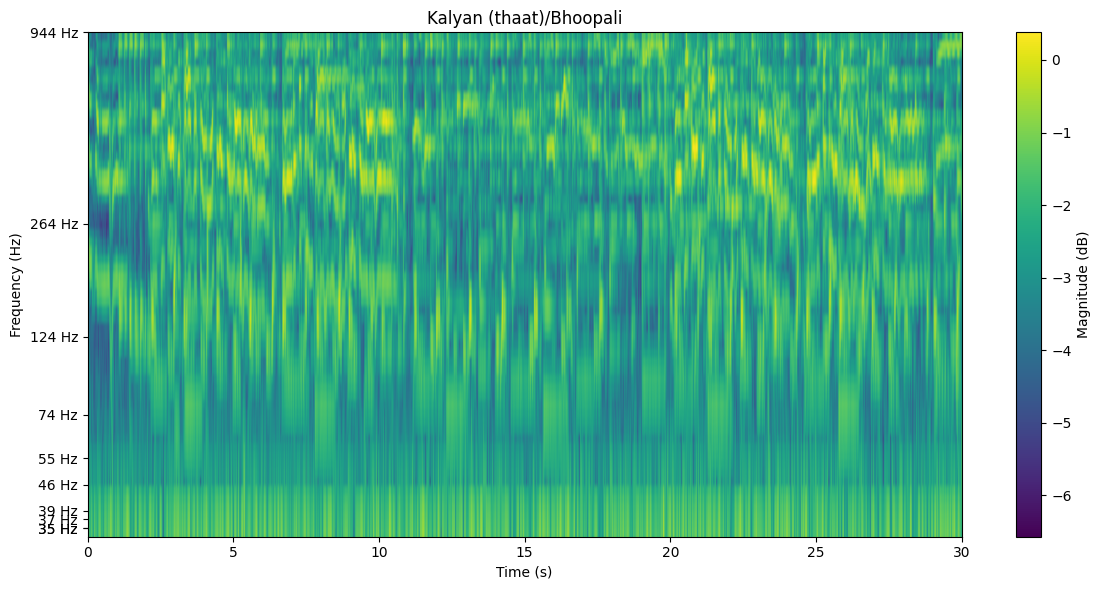

torch.Size([59, 3751])


In [14]:
features = fe(x).detach()
visualize_features(features, sample_rate=config.sample_rate, hop_length=config.hop_length, center_freqs=fe.center_freqs,
                   title=f'{ds.get_label_name(label)}', figsize=(12, 6))
print(features.shape)

In [15]:
N_examples = 128
idcs = np.random.choice(np.arange(len(ds)), size=N_examples, replace=True)
F, L = [], []
for i in tqdm(idcs):
    x, label = ds[i]
    features = fe(x).detach()
    F.append(features[None, ...])
    L.append(label)
F = torch.cat(F, dim=0)
L = torch.tensor(L)
print(F.shape, L.shape)

  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [01:35<00:00,  1.34it/s]

torch.Size([7552, 3751]) torch.Size([128])


In [7]:
def train_classification_model(X, y, config):
    model_name = config.get("model_name", "RandomForestClassifier")
    model_params = config.get("model_params", {})

    classifiers = dict(all_estimators(type_filter='classifier'))
    if model_name not in classifiers:
        raise ValueError(f"Model '{model_name}' is not a valid scikit-learn classifier.")

    model_cls = classifiers[model_name]
    model = model_cls(**model_params)

    print(model)
    model.fit(X, y)

    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", report)
    
    return model, report

In [8]:
X = F
y = L
X = summarize_features(X, window_size=32, stride=16, mode='mean')
N = X.shape[0]
X = X.reshape(N, -1)
X = dimensionality_reduction('PCA', X, n_components=32, features_flat=X, random_sate=42)
print(X.shape)

_, D = X.shape
C = np.unique(y).shape
config = {
    "model_name": "MLPClassifier",
    "model_params": {
        'hidden_layer_sizes': (32, 32, 16, 16),
    },
}

train_classification_model(X, y, config)
print(y.unique())

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
visualize_feature_embeddings(F, L, ds.get_label_names(), method='PCA', n_components=2, window_size=4, mode='mean')

In [9]:
F.shape

torch.Size([7552, 3751])